In [1]:
import numpy as np
import pandas as pd
import scipy.stats as stat
import scipy.io as scipio
import matplotlib.pyplot as plt
%matplotlib inline
import plotly as ly

## Introduction

The data comes from two separate platforms;
- __Hot Pepper Gourmet__ (hpg): An online booking site that allows users to search and book restaurants, read up on restaurant information, and find restaurant coupons. It is similar to Yelp. It has a website and applications optimized for several smartphones. 
- __AirREGI__ (air): This is used by the restaurant side as an all-in-one POS app. Allows sales and inventory management, as well as reservation control. Similar to Square.

The goal is to predict the total number of visitors for a given restaurant and a given date. 

__Dates__: The training data covers the dates from 2016 until April 2017. The test set covers the last week of April and May of 2017. The test set is split based on time (the public fold coming first, the private fold following the public) and covers a chosen subset of the air restaurants. Note that the test set intentionally spans a holiday week in Japan called the "Golden Week." The training set omits days where the restaurants were closed.

__Data Files__

- __air_reserve.csv__: This file contains reservations made in the air system. Note that the reserve_datetime indicates the time when the reservation was created, whereas the visit_datetime is the time in the future where the visit will occur.

- __hpg_reserve.csv__: This file contains reservations made in the hpg system.

- __air_store_info.csv__: This file contains information about select air restaurants. Column names and contents are self-explanatory.

- __hpg_store_info.csv__: This file contains information about select hpg restaurants. Column names and contents are self-explanatory.

- __store_id_relation.csv__: This file allows you to join select restaurants that have both the air and hpg system.

- __ air_visit_data.csv__: This file contains historical visit data for the air restaurants.

- __date_info.csv__: This file gives basic information about the calendar dates in the dataset.

In [2]:
## Load air data
air_reserve = pd.DataFrame(pd.read_csv('data/air_reserve.csv'))
air_store = pd.DataFrame(pd.read_csv('data/air_store_info.csv'))
air_visit = pd.DataFrame(pd.read_csv('data/air_visit_data.csv'))
## Load hpg data
hpg_reserve = pd.DataFrame(pd.read_csv('data/hpg_reserve.csv'))
hpg_store = pd.DataFrame(pd.read_csv('data/hpg_store_info.csv'))
## Load other data
store_id =  pd.DataFrame(pd.read_csv('data/store_id_relation.csv'))
date_info = pd.DataFrame(pd.read_csv('data/date_info.csv'))

In [3]:
air_reserve.head()

,air_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,air_877f79706adbfb06,2016-01-01 19:00:00,2016-01-01 16:00:00,1
1,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,3
2,air_db4b38ebe7a7ceff,2016-01-01 19:00:00,2016-01-01 19:00:00,6
3,air_877f79706adbfb06,2016-01-01 20:00:00,2016-01-01 16:00:00,2
4,air_db80363d35f10926,2016-01-01 20:00:00,2016-01-01 01:00:00,5


In [4]:
air_store.head()

,air_store_id,air_genre_name,air_area_name,latitude,longitude
0,air_0f0cdeee6c9bf3d7,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
1,air_7cc17a324ae5c7dc,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
2,air_fee8dcf4d619598e,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
3,air_a17f0778617c76e2,Italian/French,Hyōgo-ken Kōbe-shi Kumoidōri,34.695124,135.197852
4,air_83db5aff8f50478e,Italian/French,Tōkyō-to Minato-ku Shibakōen,35.658068,139.751599


In [5]:
air_visit.head()

,air_store_id,visit_date,visitors
0,air_ba937bf13d40fb24,2016-01-13,25
1,air_ba937bf13d40fb24,2016-01-14,32
2,air_ba937bf13d40fb24,2016-01-15,29
3,air_ba937bf13d40fb24,2016-01-16,22
4,air_ba937bf13d40fb24,2016-01-18,6


In [6]:
hpg_reserve.head()

,hpg_store_id,visit_datetime,reserve_datetime,reserve_visitors
0,hpg_c63f6f42e088e50f,2016-01-01 11:00:00,2016-01-01 09:00:00,1
1,hpg_dac72789163a3f47,2016-01-01 13:00:00,2016-01-01 06:00:00,3
2,hpg_c8e24dcf51ca1eb5,2016-01-01 16:00:00,2016-01-01 14:00:00,2
3,hpg_24bb207e5fd49d4a,2016-01-01 17:00:00,2016-01-01 11:00:00,5
4,hpg_25291c542ebb3bc2,2016-01-01 17:00:00,2016-01-01 03:00:00,13


In [7]:
hpg_store.head()

,hpg_store_id,hpg_genre_name,hpg_area_name,latitude,longitude
0,hpg_6622b62385aec8bf,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
1,hpg_e9e068dd49c5fa00,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
2,hpg_2976f7acb4b3a3bc,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
3,hpg_e51a522e098f024c,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221
4,hpg_e3d0e1519894f275,Japanese style,Tōkyō-to Setagaya-ku Taishidō,35.643675,139.668221


In [8]:
store_id.head()

,air_store_id,hpg_store_id
0,air_63b13c56b7201bd9,hpg_4bc649e72e2a239a
1,air_a24bf50c3e90d583,hpg_c34b496d0305a809
2,air_c7f78b4f3cba33ff,hpg_cd8ae0d9bbd58ff9
3,air_947eb2cae4f3e8f2,hpg_de24ea49dc25d6b8
4,air_965b2e0cf4119003,hpg_653238a84804d8e7


In [9]:
date_info.head()

,calendar_date,day_of_week,holiday_flg
0,2016-01-01,Friday,1
1,2016-01-02,Saturday,1
2,2016-01-03,Sunday,1
3,2016-01-04,Monday,0
4,2016-01-05,Tuesday,0


## Explore

(-5, 200)

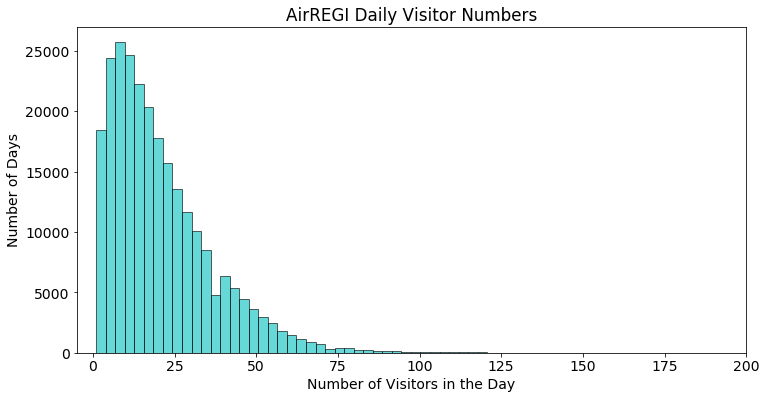

In [32]:
## Plot the visitor numbers vs days
plt.figure(figsize=(12,6))
plt.hist(air_visit['visitors'], bins=300, color='c', alpha=0.6, edgecolor='black')
plt.rcParams['font.size'] = 14
plt.title('AirREGI Daily Visitor Numbers')
plt.xlabel('Number of Visitors in the Day')
plt.ylabel('Number of Days')
plt.xlim(-5, 200)

(-5, 60)

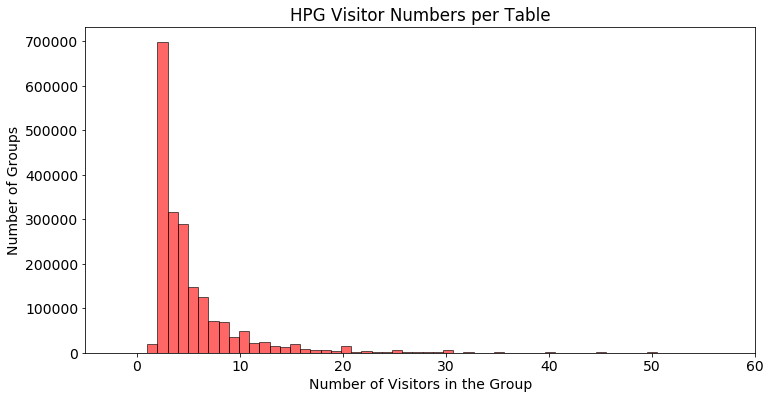

In [46]:
## Plot the HPG visitor numbers per reservation
plt.figure(figsize=(12,6))
plt.hist(hpg_reserve['reserve_visitors'], bins=100, color='r', alpha=0.6, edgecolor='black')
plt.rcParams['font.size'] = 14
plt.title('HPG Visitor Numbers per Table')
plt.xlabel('Number of Visitors in the Group')
plt.ylabel('Number of Groups')
plt.xlim(-5, 60)
# plt.xticks(np.linspace(0, 60, 30))

(-5, 60)

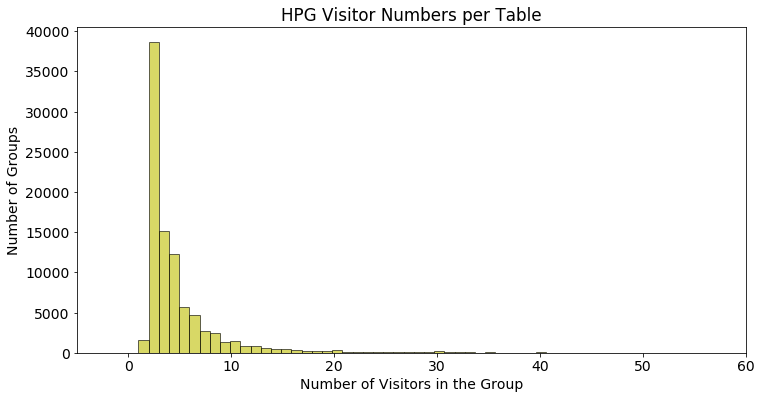

In [47]:
## Plot the AirREG visitor numbers per reservation
plt.figure(figsize=(12,6))
plt.hist(air_reserve['reserve_visitors'], bins=100, color='y', alpha=0.6, edgecolor='black')
plt.rcParams['font.size'] = 14
plt.title('HPG Visitor Numbers per Table')
plt.xlabel('Number of Visitors in the Group')
plt.ylabel('Number of Groups')
plt.xlim(-5, 60)
# plt.xticks(np.linspace(0, 60, 30))